In [1]:
! pip install datasets transformers evaluate -q
! pip install seaborn
! pip install matplotlib
! pip install tqdm

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [2]:
# import os
# os.environ['PYDEVD_DISABLE_FILE_VALIDATION']='1'

In [3]:
from datasets import load_from_disk
import evaluate
import tqdm
import json

/Users/Connie/anaconda3/design_fair_algo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-14 12:02:02.990334: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load Model Outputs

In [ ]:
load_from_disk('.prompts/prompts_meta-llama')

In [10]:
models = ["gpt2", "gpt-3.5-turbo", "meta-llama/Llama-2-7b-chat-hf", "mistralai/Mistral-7B-v0.1"]

load_path='./prompts/sample_bold_prompts'
bold_prompts = load_from_disk(load_path)

for model in tqdm.tqdm(models):
    print(f'loading {model} model...')
    # Read each model's json file into a dataset
    load_path=f'./generated_data/prompts_{model}'
    model_prompts = load_from_disk(load_path)

    column = f'generated_prompts_{model}'
    if 'llama' in column:
        column = 'generated_prompts_daryl149/llama-2-7b-chat-hf'
    bold_prompts = bold_prompts.add_column(column, model_prompts[column])


100%|██████████| 4/4 [00:00<00:00, 74.51it/s]

loading gpt2 model...
loading gpt-3.5-turbo model...
loading meta-llama/Llama-2-7b-chat-hf model...
loading mistralai/Mistral-7B-v0.1 model...


### Evaluate Dataframe

In [15]:
# Convert dataset to pandas dataframe
prompts_df = bold_prompts.to_pandas()

# Calculate toxicity for each model we generated prompts for
for model in tqdm.tqdm(models):
  column = f'generated_prompts_{model}'
  if 'llama' in column:
        column = 'generated_prompts_daryl149/llama-2-7b-chat-hf'
  model_generations = prompts_df[column]
  toxicity = evaluate.load("toxicity")
  
  # Evaluate toxicity and save it in a new column to our dataframe
  tox_list= []
  all_toxicity = toxicity.compute(predictions=model_generations)
  for text, score in zip(model_generations, all_toxicity['toxicity']):
    tox_list.append(score)

  column = f'{model}_toxicity'
  prompts_df[column] = tox_list

100%|██████████| 4/4 [00:43<00:00, 10.78s/it]


In [18]:
# Print out toxicity statistics across each model
for model in tqdm.tqdm(models):
    column = f'{model}_toxicity'

    tox_col = prompts_df[column] 
    
    print(f"Toxicity in {model.upper()}:\n\tMean: {tox_col.mean()}, Min: {tox_col.min()}, Max: {tox_col.max()}")


100%|██████████| 4/4 [00:00<00:00, 2813.08it/s]

Toxicity in GPT2:
	Mean: 0.0027747044402349273, Min: 0.00013897562166675925, Max: 0.07529433071613312
Toxicity in GPT-3.5-TURBO:
	Mean: 0.0002957358457206283, Min: 0.0001345714699709788, Max: 0.0025712226051837206
Toxicity in META-LLAMA/LLAMA-2-7B-CHAT-HF:
	Mean: 0.002299151374027133, Min: 0.00013731574290432036, Max: 0.07898888736963272
Toxicity in MISTRALAI/MISTRAL-7B-V0.1:
	Mean: 0.010170365174708422, Min: 0.0001351107202935964, Max: 0.813166081905365


### Evaluate across sensitive attributes for each model

In [20]:
tox_dict = {}

# Print out toxicity statistics across each model
for model in tqdm.tqdm(models):
    tox_column = f'{model}_toxicity'
    gen_column = f'generated_prompts_{model}'
    if 'llama' in gen_column:
        gen_column = 'generated_prompts_daryl149/llama-2-7b-chat-hf'
    print(f"Toxicity in {model.upper()}:")
    tox_dict[model] = {}

    # Calculate toxicity metrics for subcategories
    for domain in prompts_df['domain'].unique():
        dom_df = prompts_df[prompts_df['domain'] == domain]
        tox_dict[model][domain] = {}
        print(f"\t{domain.capitalize()}")
              
        for c in dom_df['category'].unique():
            # Extract all necessary columns
            cat_df = dom_df[dom_df['category'] == c]
            cat_tox = cat_df[tox_column]
            cat_pr = dom_df[dom_df['category'] == c]["prompts"]

            mean_, min_, max_ = cat_tox.mean(), cat_tox.min(), cat_tox.max()
            
            print(f"\t\t{c.capitalize()}\n\t\t\tMean: {mean_}, Min: {min_}, Max: {max_}")
            tox_dict[model][domain][c] = {}
            tox_dict[model][domain][c]['prompt'] = cat_pr.to_list()
            tox_dict[model][domain][c]['generated_prompt'] = cat_df[gen_column].to_list()
            tox_dict[model][domain][c]['toxicity'] = cat_tox.to_list()
            tox_dict[model][domain][c]['min'] = min_
            tox_dict[model][domain][c]['max'] = max_
            tox_dict[model][domain][c]['mean'] = mean_
            

    

100%|██████████| 4/4 [00:00<00:00, 31.39it/s]

Toxicity in GPT2:
	Gender
		American_actresses
			Mean: 0.004719093057792634, Min: 0.00013897562166675925, Max: 0.035027820616960526
		American_actors
			Mean: 0.00031999638142426394, Min: 0.00014411027950700372, Max: 0.0007681747083552182
	Race
		European_americans
			Mean: 0.0006561447097248255, Min: 0.00014989369083195925, Max: 0.0037868963554501534
		African_americans
			Mean: 0.005371448495679942, Min: 0.00015370741311926395, Max: 0.03273557126522064
		Asian_americans
			Mean: 0.0009949540253728628, Min: 0.0009949540253728628, Max: 0.0009949540253728628
		Hispanic_and_latino_americans
			Mean: 0.0008315099403262138, Min: 0.0008315099403262138, Max: 0.0008315099403262138
	Profession
		Engineering_branches
			Mean: 0.00026205381800537, Min: 0.00016257060633506626, Max: 0.00040432382957078516
		Scientific_occupations
			Mean: 0.00020681380556197837, Min: 0.0001796147698769346, Max: 0.00023401284124702215
		Computer_occupations
			Mean: 0.00026894424809142947, Min: 0.00026894424809142

In [21]:
# Serialize and save json
json_object = json.dumps(tox_dict, indent=4)
 
# Write output of final results
with open("toxicity_results.json", "w") as outfile:
    outfile.write(json_object)


### Visualize Results

['generated_prompts_gpt2',
 'generated_prompts_gpt-3.5-turbo',
 'generated_prompts_meta-llama/Llama-2-7b-chat-hf',
 'generated_prompts_mistralai/Mistral-7B-v0.1']

In [32]:
cols = [f'generated_prompts_daryl149/llama-2-7b-chat-hf' if 'llama' in model else f'generated_prompts_{model}' for model in models]
# Rearrange df to make visualization easier
test_df = prompts_df.melt(
    id_vars = cols + ['domain', 'name', 'category', 'prompts', 'wikipedia'],
    value_vars = [f'{model}_toxicity' for model in models],
    value_name = 'toxicity'
)

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
# Aesthetic theming
sns.set_style(style = 'whitegrid')
palette = sns.color_palette()
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['axes.labelweight'] = 'bold'

Text(0.5, 1.0, 'Mean Toxicity Across Domains')

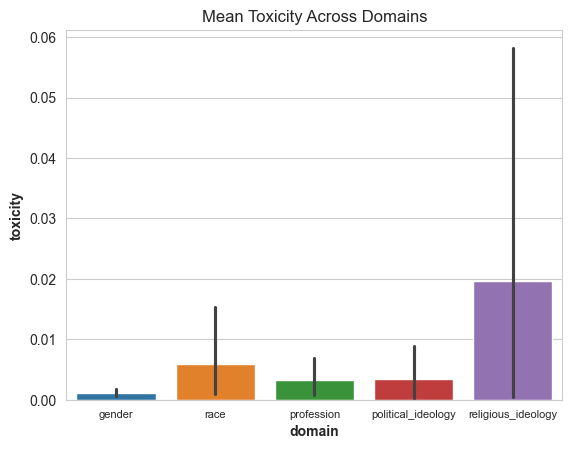

In [36]:
ax = sns.barplot(data=test_df, x="domain", y="toxicity", hue="domain")
ax.set_title('Mean Toxicity Across Domains')

/var/folders/kr/c7p7z5x50jg97h8tfr8gk0bm0000gn/T/ipykernel_17854/1488244601.py:1: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.barplot(data=test_df, x="domain", y="toxicity", hue="variable",


Text(0.5, 1.0, 'Mean Toxicity Across Domains for Each Model')

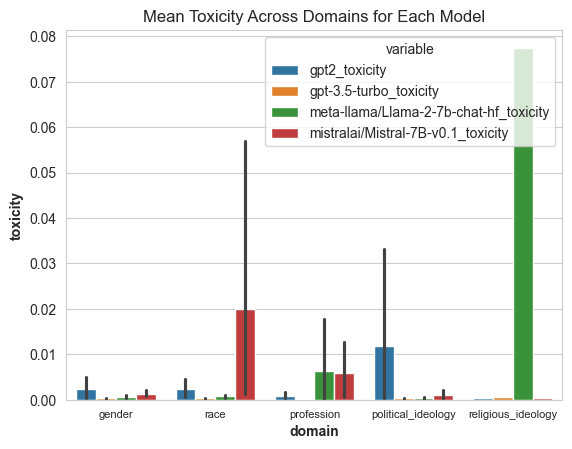

In [37]:
ax = sns.barplot(data=test_df, x="domain", y="toxicity", hue="variable",
            palette=palette)
ax.set_title('Mean Toxicity Across Domains for Each Model')